## Final Project Submission

Please fill out:
* Student name: Abigail Campbell
* Student pace: Flex
* Scheduled project review date/time: 
* Instructor name: Morgan Jones
* Blog post URL: 

### Topic 1: Recommendation Systems 
- make movie recommendations  
- based on the MovieLens dataset  
- from the GroupLens research lab at the University of Minnesota. 
- use the "small" dataset containing 100,000 user ratings (and potentially, only a particular subset of that dataset). 
 
#### Your task is to: 
- Build a model that provides top 5 movie recommendations to a user based on their ratings of other movies.  
- create the specific details about how the user will provide their ratings of other movies 
- formulate a more specific business problem within the general context of "recommending movies". 
 
#### Collaborative Filtering 
- At minimum, your recommendation system must use collaborative filtering 
- consider implementing a hybrid approach,  
- e.g. using collaborative filtering as the primary mechanism, but using content-based filtering to address the cold start problem. 
 
#### Evaluation 
- MovieLens dataset has explicit ratings  
- give some thought to the question of metrics.  
- Since the rankings are ordinal, we know we can treat this like a regression problem. 
- when it comes to regression metrics there are several choices: RMSE, MAE, etc.  

# Business Problem



## The Data



# Setup

### Import relevant packages

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import json

from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.prediction_algorithms import SVD, KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import train_test_split
from surprise import accuracy

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, mean_squared_error, r2_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, classification_report

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Load and Clean Data

In [2]:
# load raw csv files
movies_df = pd.read_csv('data/movies.csv')
ratings_df = pd.read_csv('data/ratings.csv')
tags_df = pd.read_csv('data/tags.csv')

preview Data, drop timestamp columns from all

In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = ratings_df.drop(columns=['timestamp'], axis=1)
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [5]:
tags = tags_df.drop(columns=['timestamp'], axis=1)
tags.head()

,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable
2,2,60756,will ferrell
3,2,89774,Boxing story
4,2,89774,MMA


## Create a Surprise Dataset

goal:
- make recommendations for a given user id
- based on the movies they rated highly, recommend similar movies
- use movieId to get movie title after


In [6]:
reader = Reader()
data = Dataset.load_from_df(ratings, reader)

In [7]:
dataset = data.build_full_trainset()
print(f"N users = {dataset.n_users}")
print(f"N items = {dataset.n_items}")

N users = 610
N items = 9724


# Model-Based Methods (Matrix Factorization)

## Grid Search for Params

In [8]:
params = {'n_factors': [20, 30, 40, 50, 60, 100],
          'reg_all': [0.02, 0.05, 0.1, 0.15, 0.2]}
g_s_svd = GridSearchCV(SVD, param_grid=params, n_jobs=-1)
g_s_svd.fit(data)

In [9]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8690977930475305, 'mae': 0.6680019800956856}
{'rmse': {'n_factors': 50, 'reg_all': 0.05}, 'mae': {'n_factors': 50, 'reg_all': 0.05}}


## Validate

In [10]:
# KNN Basic
knn_basic = KNNBasic(sim_options={'name': 'Pearson', 'user_based': True}, verbose=False)
cv_knn_basic = cross_validate(knn_basic, data)

for i in cv_knn_basic.items():
    print(i)
print('----------------------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([0.97018478, 0.972929  , 0.9697259 , 0.96466406, 0.97832713]))
('test_mae', array([0.74759586, 0.75325905, 0.74682919, 0.74729318, 0.75403756]))
('fit_time', (0.23910307884216309, 0.2232351303100586, 0.21920013427734375, 0.2319490909576416, 0.22109699249267578))
('test_time', (0.8028509616851807, 0.770258903503418, 0.8866770267486572, 0.8758878707885742, 0.8179121017456055))
----------------------------
0.9711661738991328


In [11]:
# KNN Baseline
knn_baseline = KNNBaseline(sim_options={'name': 'Pearson', 'user_based': True}, verbose=False)
cv_knn_baseline = cross_validate(knn_baseline, data)

for i in cv_knn_baseline.items():
    print(i)
print('----------------------------')
print(np.mean(cv_knn_baseline['test_rmse']))

('test_rmse', array([0.87588456, 0.8757303 , 0.87455354, 0.87516994, 0.87900846]))
('test_mae', array([0.6691092 , 0.66914042, 0.66897766, 0.66714335, 0.67157007]))
('fit_time', (0.26664185523986816, 0.2768571376800537, 0.2698702812194824, 0.34139180183410645, 0.2767481803894043))
('test_time', (1.0765538215637207, 1.0847229957580566, 1.0394139289855957, 1.1115961074829102, 1.0781457424163818))
----------------------------
0.8760693599232132


## Final Model

In [12]:
n_factors = g_s_svd.best_params['rmse']['n_factors']
reg_all = g_s_svd.best_params['rmse']['reg_all']

svd = SVD(n_factors=n_factors, reg_all=reg_all)
svd.fit(data.build_full_trainset())

## Get User Ratings

In [13]:
def get_user_ratings(userId):
    user_ratings = ratings[ratings.userId == userId]
    non_user_ratings = ratings[ratings.userId != userId]
    return user_ratings

## Make Recommendations

In [14]:
def rank_movies(userId):

    movies_list = []
    for movie_id in ratings.index.unique():
        user_prediction = svd.predict(userId, movie_id)
        predicted_rating = user_prediction[3]
        movies_list.append((movie_id, predicted_rating))

    ranked_movies = sorted(movies_list, key=lambda x:x[1], reverse=True)
    
    return ranked_movies

## Get Movie Names

In [15]:
def look_up_movie(movieId):
    title = movies_df[movies_df['movieId']==movieId]['title']
    title_string = title[title.index[0]]
    return title_string

## Return Recommendations

In [16]:
def get_recommended_titles(n_recs, ranked_movies):
    return [look_up_movie(id[0]) for id in ranked_movies[0:n_recs]]

## Final Function

In [83]:
def recommend_to_user(userId, n_recs):
    user_ratings = get_user_ratings(userId)
    ranked_movies = rank_movies(userId)
    print(ranked_movies[0:5])
    recommended_titles = get_recommended_titles(n_recs, ranked_movies)
    
    return recommended_titles

r = recommend_to_user(627, 15)

100836
[(318, 4.3780168495763325), (750, 4.342098334446962), (1204, 4.3218046114401165), (2959, 4.290813502889507), (858, 4.284479954694002)]


# Memory-Based Methods (Neighborhood-Based)

In [20]:
type(data)

surprise.dataset.DatasetAutoFolds

In [21]:
# train test split
trainset, testset = train_test_split(data, test_size=0.2)

In [108]:
sim_cos = {"name": "cosine", "user_based": False}
sim_pearson = {"name": "pearson", "user_based": False}

In [105]:
sim_cos = {"name": "cosine", "user_based": False}
basic_cos = KNNBasic(sim_options=sim_cos)
basic_cos.fit(trainset)
predictions_basic_cos = basic_cos.test(testset)
print(accuracy.rmse(predictions_basic_cos))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9710
0.9709873189790583


In [107]:
basic_pearson = KNNBasic(sim_options=sim_pearson)
basic_pearson.fit(trainset)
predictions_basic_pearson = basic_pearson.test(testset)
print(accuracy.rmse(predictions_basic_pearson))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9696
0.969605251424121


In [23]:
means_2 = KNNWithMeans(sim_options=sim_pearson)
means_2.fit(trainset)
predictions_means = means_2.test(testset)
print(accuracy.rmse(predictions_means))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9009
0.9009062749102176


In [24]:
baseline_2 = KNNBaseline(sim_options=sim_pearson)
baseline_2.fit(trainset)
predictions_base = baseline_2.test(testset)
print(accuracy.rmse(predictions_base))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8786
0.878623887368811


In [34]:
baseline_2.predict(420, 627)

Prediction(uid=420, iid=627, r_ui=None, est=3.69255227265062, details={'actual_k': 24, 'was_impossible': False})

### Define the Final Model

In [ ]:
final_model = basic_cos

# Cold Start Problem

## Recommend the top 5 highest rated movies and most rated movies
- movies with highest ratings with a certain # of ratings above
- continue until you have a threshold of ratings

In [99]:
# get average ratings and number of ratings for each movie id
ratings_avg = ratings.groupby('movieId').mean()
ratings_count = ratings.groupby('movieId').count()
ratings_avg.head()

# combine average and count into one stats dataframe
ratings_stats = ratings_avg.drop(columns='userId')
ratings_stats["n_ratings"] = ratings_count['userId']

# drop all movies with less than 10 ratings
ratings_stats = ratings_stats[ratings_stats['n_ratings'] > 50]

# order the movies by highest rank and highest number of ratings
ratings_stats_by_rating = ratings_stats.sort_values(by='rating', ascending=False)
ratings_stats_by_count = ratings_stats.sort_values(by='n_ratings', ascending=False)

### Top 5 highest rated movies

In [102]:
def top_movies(n_movies, ratings):
    return [look_up_movie(movie_id) for movie_id in ratings[0:n_movies].index]

top_movies(5, ratings_stats_by_rating)
top_movies(5, ratings_stats_by_count)

['Forrest Gump (1994)',
 'Shawshank Redemption, The (1994)',
 'Pulp Fiction (1994)',
 'Silence of the Lambs, The (1991)',
 'Matrix, The (1999)']

# Full Data Set Visualizations

Initial visualizations to get a look into the data set

## Create a new table with just movie id and tag - including genres as tags

### Format movies table

In [25]:
# convert genres into tags
movies = movies_df.rename(columns={'genres': 'tag'})

# convert genre tags to list
movies['tag'] = movies['tag'].map(lambda x: x.split('|'))
movies = movies.explode('tag')

movies.head()

,movieId,title,tag
0,1,Toy Story (1995),Adventure
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children
0,1,Toy Story (1995),Comedy
0,1,Toy Story (1995),Fantasy


In [26]:
genres = movies.drop(columns=['title'], axis=1)
just_tags = tags.drop(columns=['userId'], axis=1)

In [27]:
df_tags = pd.concat([genres, just_tags])
df_tags = df_tags.set_index('movieId')
df_tags.tail()

,tag
movieId,
7382,for katie
7936,austere
3265,gun fu
3265,heroic bloodshed
168248,Heroic Bloodshed


In [28]:
just_tags.value_counts().sort_values(ascending=False)

movieId  tag              
260      sci-fi               3
60756    funny                3
79132    thought-provoking    3
4226     twist ending         3
260      classic sci-fi       3
                             ..
168252   dark                 1
         emotional            1
         gritty               1
         heartbreaking        1
924      future               1
Length: 3579, dtype: int64

In [29]:
tags_group = just_tags.groupby('tag').count().sort_values(by='movieId', ascending=False)
tags_group = tags_group[tags_group['movieId']>1]
tags_frequent = list(tags_group.index)
filtered_tag_df = df_tags[df_tags['tag'].isin(tags_frequent)]
filtered_tag_df.value_counts()

tag               
Comedy                3760
Action                1832
Mystery                576
In Netflix queue       131
atmospheric             36
                      ... 
alternate universe       2
narrated                 2
alternate endings        2
neo-noir                 2
drug abuse               2
Length: 551, dtype: int64

In [30]:
ohe = OneHotEncoder()
tag_ohe = ohe.fit_transform(filtered_tag_df).toarray()
ohe_df = pd.DataFrame(tag_ohe, columns=ohe.get_feature_names_out(filtered_tag_df.columns))
ohe_df.head()

,tag_06 Oscar Nominated Best Movie - Animation,tag_1920s,tag_1950s,tag_1970s,tag_1980s,tag_AIDs,tag_Aardman,tag_Action,tag_Adam Sandler,tag_Africa,...,tag_wedding,tag_weddings,tag_weird,tag_whimsical,tag_white guilt,tag_widows/widowers,tag_will ferrell,tag_witty,tag_writing,tag_zombies
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Look at the genres

Text(0.5, 1.0, 'Number of Movies in Each Genre')

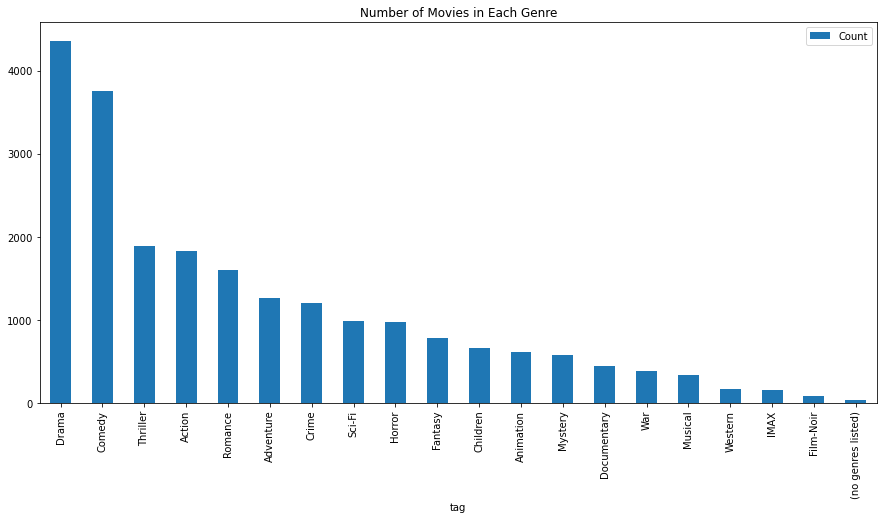

In [31]:
genres_group = genres.groupby('tag').count().sort_values(by='movieId', ascending=False)
genres_group = genres_group.rename(columns={'movieId': 'Count'})
genres_group.plot.bar(figsize=(15,7))
plt.title('Number of Movies in Each Genre')

## Look at the tags

Text(0.5, 1.0, 'Number of Movies with Top 15 Tabs')

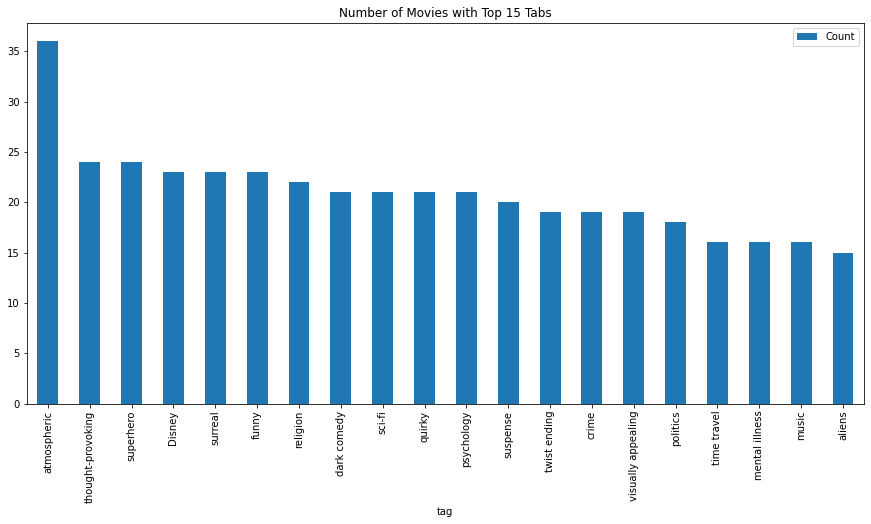

In [32]:
tags_group = just_tags.groupby('tag').count().sort_values(by='movieId', ascending=False)[1:21]
# tags_group = tags_group.drop(columns=['userId'], axis=1)
tags_group = tags_group.rename(columns={'movieId': 'Count'})
tags_group.plot.bar(figsize=(15,7))
plt.title('Number of Movies with Top 15 Tabs')

# Base Model

## Evaluate the base model performance

Which value will be our primary metric?

# Model Tuning